# Part 1 Topic Modelling

The main idea of the first part is to extract information from the news articles for later classification with IAB categories. This is done with KeyBERT and BERTopic. Before applying KeyBERT and BERTopic the text was preprocessed with the following steps:


*   tokenisation
*   removal of stop words
*   lemmatization
*   removal of extra stops word to remove pure financial information

In the second part of the assignment it was chosen to assign industries to this finanical information. Therefore dominant information about pure financial topics are considered to make the classification in the second part of the assignment more difficult.

KeyBERT was used to extract keywords from each news article. Those keywords should reflect the very specific content of a single news article. BERTopic was used for topic modelling. The representative words of a topic for each news article should give a more general impression of the content of the corresponding article.

BERTopic delivers a category called -1. This category consists of outliers. The goal of the project is to give advertisers a safe indication about the content of an article and thereby security about the environment of their ads and the potential impact on their brand. Therefore those 3798 outlier news articles of category -1 have not been used in the second part of the assignment. 








## Basic structure of the topic modelling part

The project is structured the following way:

<ul>
    <li>Import libraries</li>
    <li>General data cleaning</li>
    <li>Text preprocessing</li>
    <li>Data transformation: Corpus and Dictionary</li>
    <li>Exploring various models</li>
    <li>Removing high frequency and extreme words</li>
    <li>Selection of number topics</li>
    <li>Hyperparameter Tuning</li>
    <li>Final Model</li>
<ul>    
    
    

## Sources
https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6 

https://www.pinecone.io/learn/bertopic/#back-to-bertopic 

https://github.com/pinecone-io/examples/tree/master/learn/algos-and-libraries/bertopic 

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#selecting-min-cluster-size

https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea



In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:

!pip install umap-learn
!pip install hdbscan
!pip install bertopic
!pip install KeyBERT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 27.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=6e0ddee2a800f44f37fa9d7c742688a2d90e963a1781e27aa4d217da37170c7f
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=346b6bb5ca7e20ee6bc1dc0adad0af081fd2a64dfb9ade6673c6bcae983eca98
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requir

In [3]:
import nltk
import json
import numpy as np
import pandas as pd
import tqdm
import umap.umap_ as umap
import hdbscan
import bertopic
import re, random, os
import string, pprint
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import reuters
from nltk.corpus import stopwords
nltk.download('reuters')
nltk.download('stopwords')
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Reuters Dataset and check whats inside

In [4]:
print(">>> The reuters corpus has {} tags".format(len(reuters.categories())))
print(">>> The reuters corpus has {} documents".format(len(reuters.fileids())))

>>> The reuters corpus has 90 tags
>>> The reuters corpus has 10788 documents


## Generate a frequency table 

In [5]:
# create counter to summarize
categories = []
file_count = []

# count each tag's number of documents
for i in reuters.categories():
    """print("$ There are {} documents included in topic \"{}\""
          .format(len(reuters.fileids(i)), i))"""
    file_count.append(len(reuters.fileids(i)))
    categories.append(i)

# create a dataframe out of the counts
df = pd.DataFrame(
    {'categories': categories, "file_count": file_count}) \
    .sort_values('file_count', ascending=False)
print(df.head())

   categories  file_count
21       earn        3964
0         acq        2369
46   money-fx         717
26      grain         582
17      crude         578


## Creating pandas dataframe

In [6]:
# Extract fileids from the reuters corpus
fileids = reuters.fileids()

# Initialize empty lists to store categories and raw text
categories = []
text = []

# Loop through each file id and collect each files categories and raw text
for file in fileids:
    categories.append(reuters.categories(file))
    text.append(reuters.raw(file))

# Combine lists into pandas dataframe. reutersDf is the final dataframe. 
reutersDf = pd.DataFrame({'ids':fileids, 'categories':categories, 'text':text})

In [7]:
reutersDf

ids                                      categories  \
0         test/14826                                         [trade]   
1         test/14828                                         [grain]   
2         test/14829                                [crude, nat-gas]   
3         test/14832  [corn, grain, rice, rubber, sugar, tin, trade]   
4         test/14833                             [palm-oil, veg-oil]   
...              ...                                             ...   
10783   training/999                            [interest, money-fx]   
10784  training/9992                                          [earn]   
10785  training/9993                                          [earn]   
10786  training/9994                                          [earn]   
10787  training/9995                                          [earn]   

                                                    text  
0      ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...  
1      CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...  
2      JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...  
3      THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n  ...  
4      INDONESIA SEES CPO PRICE RISING SHARPLY\n  Ind...  
...                                                  ...  
10783  U.K. MONEY MARKET SHORTAGE FORECAST REVISED DO...  
10784  KNIGHT-RIDDER INC &lt;KRN> SETS QUARTERLY\n  Q...  
10785  TECHNITROL INC &lt;TNL> SETS QUARTERLY\n  Qtly...  
10786  NATIONWIDE CELLULAR SERVICE INC &lt;NCEL> 4TH ...  
10787  &lt;A.H.A. AUTOMOTIVE TECHNOLOGIES CORP> YEAR ...  

[10788 rows x 3 columns]

## Text preprocessing

The preprocessing pipeline is mentioned below.
#### 1. Tokenisation
I use gensim's simple_preprocess. 

In [8]:
# Tokenization using gensim
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  
        
# Convert the data to a list
data = reutersDf['text'].values.tolist()
data_words = list(sent_to_words(data))

# Preview of the data
print(data_words[1])

['china', 'daily', 'says', 'vermin', 'eat', 'pct', 'grain', 'stocks', 'survey', 'of', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume', 'between', 'seven', 'and', 'pct', 'of', 'china', 'grain', 'stocks', 'the', 'china', 'daily', 'said', 'it', 'also', 'said', 'that', 'each', 'year', 'mln', 'tonnes', 'or', 'pct', 'of', 'china', 'fruit', 'output', 'are', 'left', 'to', 'rot', 'and', 'mln', 'tonnes', 'or', 'up', 'to', 'pct', 'of', 'its', 'vegetables', 'the', 'paper', 'blamed', 'the', 'waste', 'on', 'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', 'it', 'said', 'the', 'government', 'had', 'launched', 'national', 'programme', 'to', 'reduce', 'waste', 'calling', 'for', 'improved', 'technology', 'in', 'storage', 'and', 'preservation', 'and', 'greater', 'production', 'of', 'additives', 'the', 'paper', 'gave', 'no', 'further', 'details']


#### 2. Stop word removal 
Code below creates a stopword list, including a list of punctuation characters from string.punctuation, which is from 
the string module.

In [9]:
# Create stopword list
# string.punctuation refers to a list of punctuations
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + list(string.punctuation)

In [10]:
# create list of additional stop words
# We remove additional common words that occur in many documents and have no link to a distinct industry. So those terms are just financial in general and therefore we remove them to enchance our results.
additional_stop_words = ["oper","expect","first","rise","fall","sqd","common","agreement","merger","acquisition","nil","end","rd","mth","ago","show","sentiment","fear","thailand","widen","shr","shrs","term","chinese","china","taiwanese","earn","note","omc","mthly","buy","sell","merge","offer","credit","tax","qtr","shr","avg","acquire","usd","usda","tonne","qtrly","rate","franc","germany","german","korean","trade","tariff","see","yen","euro","dollar","dollars","japanese","japan","indonesia","japanese","philippine","australian","market","australia","survey","surveys","revs","mln","said","payout","check","bill","day","week","net","revenue","revenues","price","month","set","loss","pct","pay","payble","say","year","ct","pay","growth","money","profit","profits","currency","branch","branches","sale", "sales", "dlr", "dlrs","share","shares","stock","stocks","company","companies","prior","shareholders","shareholder","firm","firms","quarterly","qtly","quarter"]
stop_words = stop_words + additional_stop_words

In [11]:
# Removing the stopwords from the data
def rem_stopwords (text):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text]

# remove stop words
data_words_nostops = rem_stopwords(data_words)

#### 3. Lemmatization

In [12]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [13]:
# remove stop words
data_lemmatized = rem_stopwords(data_lemmatized)

In [14]:
# Preview of nonstop, lemmatised version of the content
print(data_lemmatized[1])

['vermin', 'eat', 'grain', 'province', 'city', 'vermin', 'consume', 'grain', 'daily', 'also', 'fruit', 'output', 'leave', 'rot', 'vegetable', 'paper', 'blame', 'waste', 'inadequate', 'storage', 'bad', 'preservation', 'method', 'government', 'launch', 'national', 'programme', 'reduce', 'waste', 'call', 'improve', 'technology', 'storage', 'preservation', 'great', 'production', 'additive', 'paper', 'give', 'detail']


## Preprocessed dataframe

In [15]:
reutersDf['text'] = data_lemmatized
reutersDf['text'] = [','.join(map(str, l)) for l in reutersDf['text']]
reutersDf['categories'] = [','.join(map(str, l)) for l in reutersDf['categories']]

In [16]:
reutersDf

ids                              categories  \
0         test/14826                                   trade   
1         test/14828                                   grain   
2         test/14829                           crude,nat-gas   
3         test/14832  corn,grain,rice,rubber,sugar,tin,trade   
4         test/14833                        palm-oil,veg-oil   
...              ...                                     ...   
10783   training/999                       interest,money-fx   
10784  training/9992                                    earn   
10785  training/9993                                    earn   
10786  training/9994                                    earn   
10787  training/9995                                    earn   

                                                    text  
0      asian,exporter,damage,rift,mount,friction,rais...  
1      vermin,eat,grain,province,city,vermin,consume,...  
2      revise,long,energy,demand,revise,long,energy,s...  
3      deficit,deficit,baht,business,janunary,import,...  
4      cpo,sharply,crude,palm,oil,cpo,sharply,fob,som...  
...                                                  ...  
10783  shortage,forecast,revise,revise,forecast,short...  
10784                                                     
10785                                             record  
10786                                                     
10787                                             dilute  

[10788 rows x 3 columns]

Each row is a news document. For each news document you will have an unique id, category/categories that describe the document, and the documents raw text. There are 10,788 total observations.

## KeyBERT keyword extraction 

KeyBERT is a powerful method that utilizes BERT embeddings and cosine similarity in order to extract keywords and keyphrases from a document. The pipeline is simple. Firstly, BERT extracts the document embeddings in order to have a document-level representation. After that, word embeddings are extracted for specific n-gram words or phrases. Last but not least, it utilizes simple cosine similarity to the appropriate words or phrazes that have the most similarity with the respective document.

Having in mind that the most similar words are the ones that can best describe a document, we value them as keywords.

Also, even though that exist other solutions for for task, we should into mind that KeyBERT is the first solution that is beginner friendly and the model does not need to be trained from scratch.

In [17]:
#Load the KeyBERT model
from keybert import KeyBERT
kw_model = KeyBERT()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [18]:
reutersDf["text"][1]

'vermin,eat,grain,province,city,vermin,consume,grain,daily,also,fruit,output,leave,rot,vegetable,paper,blame,waste,inadequate,storage,bad,preservation,method,government,launch,national,programme,reduce,waste,call,improve,technology,storage,preservation,great,production,additive,paper,give,detail'

In [19]:
# Extract top 5 keywords unigrams
kw_model.extract_keywords(reutersDf["text"][2], keyphrase_ngram_range=(1,1))

[('energy', 0.3788),
 ('revise', 0.3615),
 ('coal', 0.3401),
 ('demand', 0.3148),
 ('electric', 0.2879)]

In [20]:
# Extract top 5 multi-word key phrases, ranging from unigrams to trigrams.
kw_model.extract_keywords(reutersDf["text"][0], keyphrase_ngram_range=(1, 3))

[('asian exporter', 0.4157),
 ('asian exporter damage', 0.4075),
 ('retaliation exporter', 0.3686),
 ('foreign', 0.354),
 ('retaliation exporter group', 0.3438)]

In [21]:
# Extract top 10 multi-word key phrases, ranging from unigrams to trigrams.
kw_model.extract_keywords(reutersDf["text"][0], keyphrase_ngram_range=(1, 3),top_n=10)

[('asian exporter', 0.4157),
 ('asian exporter damage', 0.4075),
 ('retaliation exporter', 0.3686),
 ('foreign', 0.354),
 ('retaliation exporter group', 0.3438),
 ('diplomatic', 0.3384),
 ('possible retaliation exporter', 0.3342),
 ('help swell foreign', 0.332),
 ('chief export similar', 0.3235),
 ('exporter damage', 0.3232)]

In [22]:
# Extract multi-word key phrases, ranging from unigrams to bigrams for all the reutersDf articles.

# empty list to store keywords for all documents
keywords_for_all_documents = []

for index in range(len(reutersDf)):
    keywords_for_document = (kw_model.extract_keywords(reutersDf["text"][index], keyphrase_ngram_range=(1, 2) ))
    # extract keywords from output of KeyBERT
    keywords_clean = [keyword for keyword, prob in keywords_for_document]
    keywords_clean = ", ".join(keywords_clean)
    keywords_for_all_documents.append(keywords_clean)

In [23]:
# add keywords to reuterDf for later usage for zero-shot learning and IAB classification
reutersDf.insert(3, "keywords", keywords_for_all_documents)

## BERTopic modeling detailed

There are four key components used in BERTopic, these are: 
<ul>
    <li>A transformer embedding model</li>
    <li>UMAP dimensionality reduction</li>
    <li>HDBSCAN clustering</li>
    <li>Cluster tagging using c-TF-IDF</li>
<ul>

All of this is already done in those few lines of BERTopic code; everything is just abstracted away. However, we can optimize the process by understanding the essentials of each component. This section will work through each component without BERTopic, and learn how they work before returning to BERTopic at the end.

## Transformer embedding
BERTopic supports several libraries for encoding our text to dense vector embeddings. If we build poor quality embeddings, nothing we do in the other steps will be able to help us, so it is very important that we choose a suitable embedding model. the Sentence Transformers library provides the most extensive library of high-performing sentence embedding models.They can be found on HuggingFace Hub by searching for “sentence-transformers”. The first result of this search is sentence-transformers/all-MiniLM-L6-v2, this is a popular high-performing model that creates 384-dimensional sentence embeddings.

In [24]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

Then we create embeddings

In [25]:
embeddings = model.encode(text, show_progress_bar=True)

Batches:   0%|          | 0/338 [00:00<?, ?it/s]

## Dimensionality reduction 
After building the embeddings, BERTopic compresses them into a lower-dimensional space. This means that our 384-dimensional vectors are transformed into lesser dimensional vectors.

We can do this because 384 dimensions are a lot, and it is unlikely that we really need that many dimensions to represent our text. Instead, we attempt to compress that information into less dimensions. We do this so that the following HDBSCAN clustering step can be done more efficiently. Performing the clustering step with 384-dimensions would be desperately slow.

The UMAP algorithm can be finetuned using several parameters. Still, the simplest and most effective tuning can be achieved with just the n_neighbors parameter. By increasing n_neighbors we can preserve more global structures, whereas a lower n_neighbors better preserves local structures, finding a good n_neighbours value allows us to preserve both local and global structures relatively well. Note that a too low dimensionality (n_components) results in a loss of information while a too high dimensionality results in poorer clustering results. The cosine parameter controls how distance is computed in the ambient space of the input data and the min_dist is included to allow UMAP to place points closer together (the default value is 1.0). We will play around with different values for the UMAP parameters in the final model to optimize our topics. An example of the UMAP can be seen below.

In [26]:
import umap.umap_ as umap

In [27]:
umap_embeddings = umap.UMAP(n_neighbors=10, 
                            n_components=3, 
                            min_dist=0.05,
                            metric = 'cosine').fit_transform(embeddings)

#### What didn't work
Normally this step can be accompanied by testing several UMAP parameters and visualizing the results. When training the model different values of n_neighboars and n_components can be plotted. When you analyze the plotted results a choise can be made based on best performance of the plots by looking at which parameter combinations give the strongest splits between the different "tags". Since almost every document in our dataset has several tags it is not possible to plot every document based on 1 tag and thus make a meaningfull plot. 

The code below shows how this should work: 

https://github.com/pinecone-io/examples/blob/master/learn/algos-and-libraries/bertopic/05_topic_model_detail.ipynb

In [28]:
# colors = reuters.categories()
# c_map = {
#     colors : colorcode
# }
# colors = [c_map[x] for x in colors]

In [29]:
# fig, ax = plt.subplots(3, 3, figsize=(14, 14))
# nns = [2, 3, 4, 5, 10, 15, 30, 50, 100]
# i, j = 0, 0
# for n_neighbors in tqdm(nns):
#    fit = umap.UMAP(n_neighbors=n_neighbors)
#    u = fit.fit_transform(embeddings)
#    sns.scatterplot(x=u[:,0], y=u[:,1], c=colors, ax=ax[j, i])
#    ax[j, i].set_title(f'n={n_neighbors}')
#    if i < 2: i += 1
#    else: i = 0; j += 1

## HDBSCAN Clustering

After having reduced the dimensionality of the documents embeddings to 3, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

In [30]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

Results will be stored in the label_ attribute of the cluser. 

In [31]:
cluster.labels_

array([ 49,  77,  -1, ...,   7, 121, 107])

We now have clustered similar documents together which should represent the topics that they consist of. To visualize the resulting clusters we can further reduce the dimensionality to 2 and visualize the outliers as grey points:

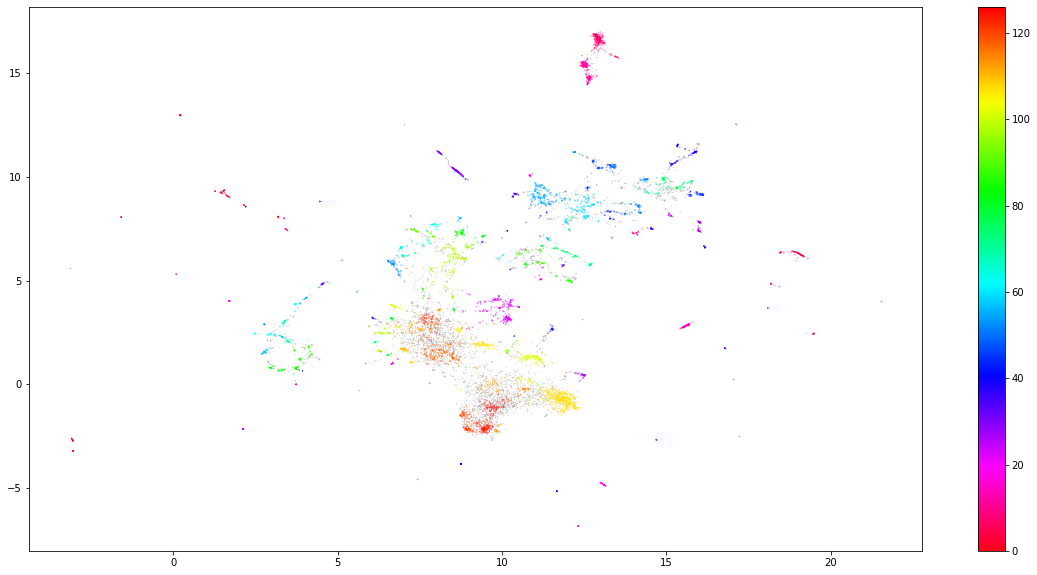

In [32]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.05, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

We can view the condensed tree plot which shows the point drop off and also splitting of clusters as clustering parameters are shifted. This visualizes the process that has been used by HDBSCAN to identify clusters. At a high-level this is by identifying the cluster segments/roots with the largest area (those circled).

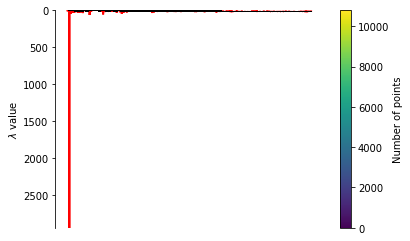

In [33]:
cluster.condensed_tree_.plot(select_clusters=True)

In this case the algorithm has chosen tiny clusters, so small that we cannot even see the circled clusters in the condensed tree plot (those red lines are circles...). By default the minimum number of points to "create" a cluster is just 15, given a dataset of ~11K points where we are aiming to produce ~40 tag clusters, this is very small. We can therefore increase this min_cluster_size to return better results.

In [34]:
cluster = hdbscan.HDBSCAN(min_cluster_size=25,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

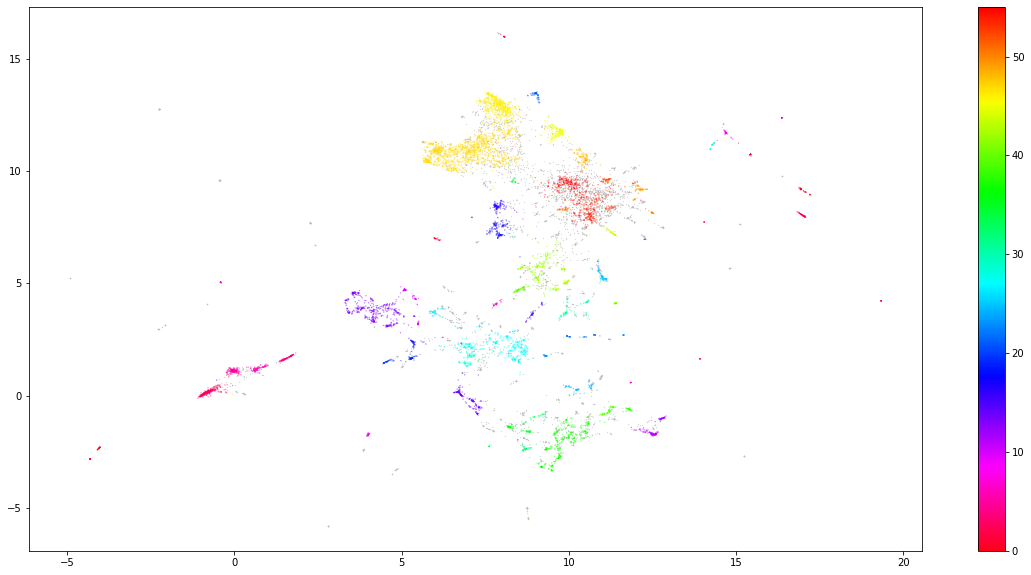

In [35]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.05, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Increasing the min_cluster_size to 25 reduces the number of clusters, merging some together. This is a result of HDBSCAN* reoptimizing which flat clustering provides greater stability under a slightly different notion of what constitutes a cluster.

If we take a look at the condensed tree plot we can also see a clearer tree.

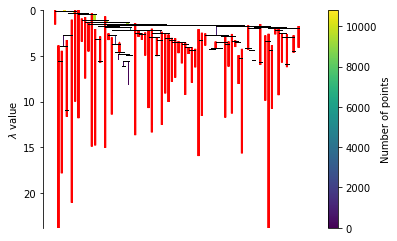

In [36]:
cluster.condensed_tree_.plot(select_clusters=True)

Doubling the min_cluster_size again to 50 gives us again less clusters – the really core clusters. This is somewhat as expected, but surely some of the other clusters that we had previously had more than 50 members? Why are they being considered noise? The answer is that HDBSCAN* has a second parameter min_samples. The implementation defaults this value (if it is unspecified) to whatever min_cluster_size is set to.

In [37]:
cluster = hdbscan.HDBSCAN(min_cluster_size=50,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

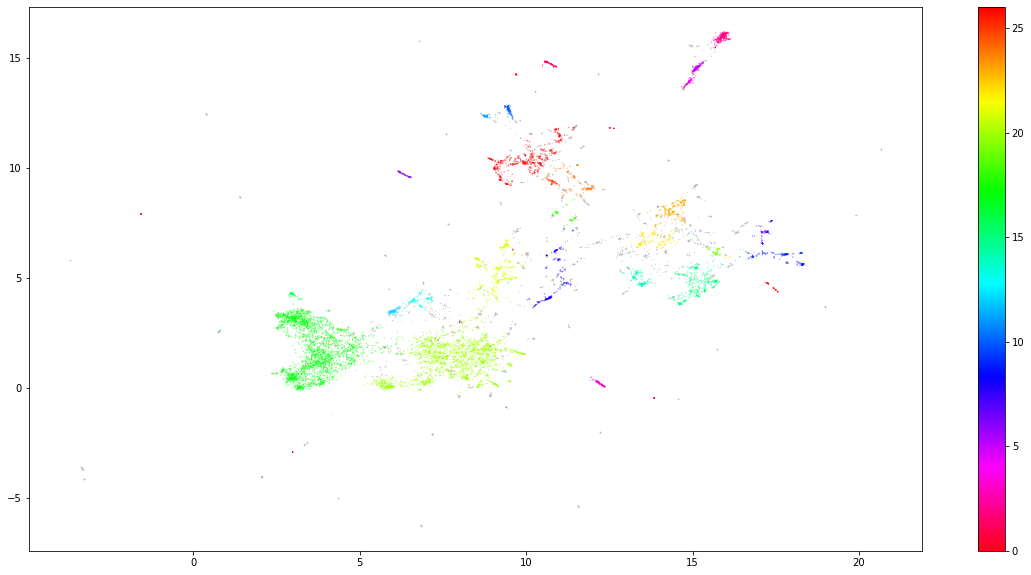

In [38]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.05, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

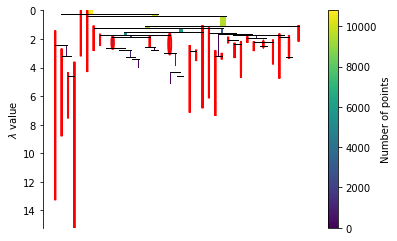

In [39]:
cluster.condensed_tree_.plot(select_clusters=True)

We can recover some of our original clusters by explicitly providing min_samples at the original value of 15.

In [40]:
cluster = hdbscan.HDBSCAN(min_cluster_size=50, min_samples = 15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

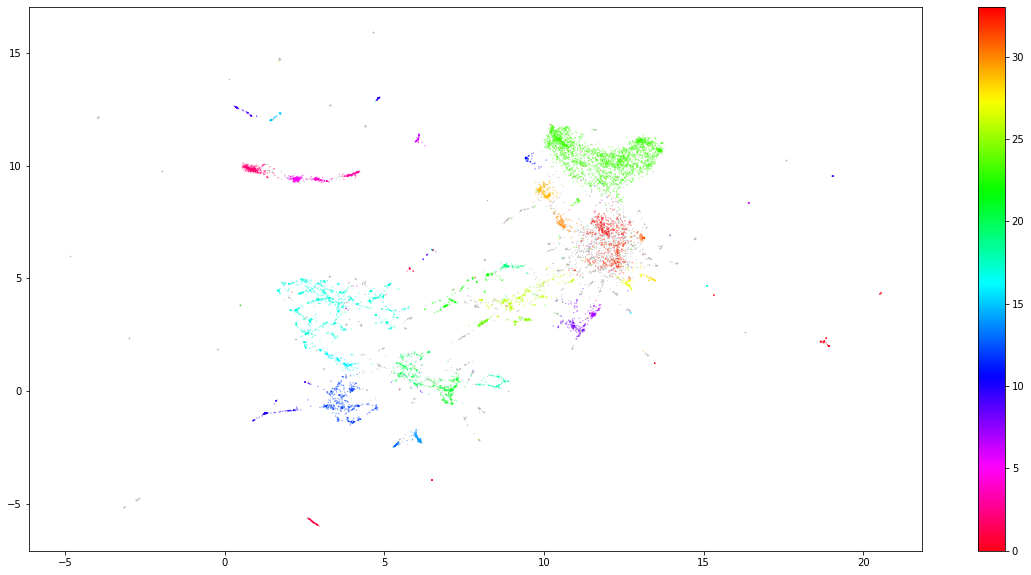

In [41]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.05, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

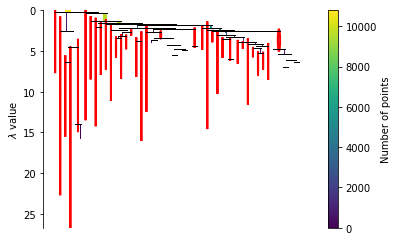

In [42]:
cluster.condensed_tree_.plot(select_clusters=True)

As you can see this results in us recovering something much closer to our original clustering, only now with some of the smaller clusters pruned out. Thus min_cluster_size does behave more closely to our intuitions, but only if we fix min_samples.

## Cluster tagging using c-TF-IDF

What we want to know from the clusters that we generated, is what makes one cluster, based on their content, different from another?

How can we derive topics from clustered documents?

To solve this, a class-based variant of TF-IDF (c-TF-IDF), would allow us to extract what makes each set of documents unique compared to the other.

The intuition behind the method is as follows. When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.

What if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

## c-TF-IDF

Part of c-TF-IDF requires calculating the frequency of term t in class c. For that, we need to see which tokens belong in each class. We first add the cluster/class labels to data.

In [43]:
docs_df = pd.DataFrame(reutersDf, columns=["text"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'text': ' '.join})

Then, we apply the class-based TF-IDF:

In [44]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.text.values, m=len(reutersDf))

Now, we have a single importance value for each word in a cluster which can be used to create the topic. If we take the top 10 most important words in each cluster, then we would get a good representation of a cluster, and thereby a topic.

#### Topic Representation
In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [45]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "text": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

Topic  Size
24     23  2467
0      -1  2400
18     17  1042
13     12   453
3       2   325
27     26   300
33     32   285
34     33   272
22     21   268
21     20   241

The topic name -1 refers to all documents that did not have any topics assigned. The great thing about HDBSCAN is that not all documents are forced towards a certain cluster. If no cluster could be found, then it is simply an outlier.

We can see that topics 21, 36, 24, and 10 are the largest clusters that we could create. To view the words belonging to those topics, we can simply use the dictionarytop_n_words to access these topics:

In [46]:
top_n_words[1][:10]

[('attack', 0.08659648216045235),
 ('iranian', 0.07944920793409338),
 ('missile', 0.055020473873626935),
 ('ship', 0.049061728980088454),
 ('tanker', 0.04353847163274575),
 ('platform', 0.042357438863682546),
 ('military', 0.03563798085064103),
 ('escort', 0.03277588054846839),
 ('warship', 0.03252028430546214),
 ('shipping', 0.030195145057329363)]

In [47]:
top_n_words[2][:10]

[('record', 0.49291794107421705),
 ('march', 0.2732629197352443),
 ('regular', 0.11416208965983146),
 ('insure', 0.11327187998944292),
 ('distribution', 0.11120289972049938),
 ('payable', 0.08081508584378884),
 ('raise', 0.061951016719861106),
 ('fund', 0.05649250026344518),
 ('income', 0.054686054484855806),
 ('free', 0.05270167405222793)]

In [48]:
top_n_words[3][:10]

[('split', 0.414061088248606),
 ('dividend', 0.10322142617052786),
 ('declare', 0.10308556652406506),
 ('payable', 0.10019799634105406),
 ('record', 0.08614649630625425),
 ('authorize', 0.0670717221638246),
 ('holder', 0.06431433146288551),
 ('approve', 0.061289525699682025),
 ('annual', 0.05134872781238551),
 ('vote', 0.05036414038508958)]

In [49]:
top_n_words[21][:10]

[('index', 0.053172575107179425),
 ('inflation', 0.0359892257062086),
 ('industrial', 0.029491327303563956),
 ('consumer', 0.02826931034902556),
 ('compare', 0.024060568451372714),
 ('output', 0.022420703972312595),
 ('gdp', 0.021975668753113027),
 ('economic', 0.021591083613558822),
 ('increase', 0.020928126069883188),
 ('good', 0.019725515645245793)]

In [50]:
top_n_words[30][:10]

[('saving', 0.07941754762965515),
 ('asset', 0.06130698643700174),
 ('federal', 0.04932401151781622),
 ('city', 0.04669219607350357),
 ('loan', 0.0462939544789587),
 ('bank', 0.04127002676012636),
 ('association', 0.03550410966484081),
 ('regulatory', 0.03436681282988643),
 ('approval', 0.0342100739091676),
 ('subject', 0.02867918652836465)]

In [51]:
top_n_words[24][:10]

[('oil', 0.054652072687085086),
 ('bpd', 0.051531301873274156),
 ('barrel', 0.04401960935632649),
 ('opec', 0.04346466797745919),
 ('output', 0.04266678477354318),
 ('crude', 0.03382371003104962),
 ('production', 0.03122021457620372),
 ('ceiling', 0.029250010062832926),
 ('saudi', 0.025535651009070306),
 ('member', 0.02482717915921599)]

In [52]:
top_n_words[10][:10]

[('band', 0.061347628153448575),
 ('sterling', 0.049174787345890196),
 ('shortage', 0.04772107008190543),
 ('assistance', 0.04298059697910405),
 ('today', 0.038149309485686136),
 ('bank', 0.035600392229390806),
 ('point', 0.033193649808125954),
 ('revise', 0.03063723302956166),
 ('cut', 0.0303695533937615),
 ('forecast', 0.028282561039442565)]

In [53]:
print(">>> BERTopic modeling has created {} topics".format(len(top_n_words)))

>>> BERTopic modeling has created 35 topics


Looking at the largest four topics, I would say that these nicely seem to represent easily interpretable topics! And the number of topics comes close to a reasonable amount. 

## BERTopic modeling and its parameters

To pass the level of custom parameters the we used in the previous chapter to BERTopic, we actually initialize our own instances of UMAP and HDBSCAN.

In [54]:
import umap.umap_ as umap
from hdbscan import HDBSCAN

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# umap_model = UMAP(n_neighbors=10, 
#                   n_components=3, 
#                   min_dist=0.05,
#                   metric = 'cosine')
hdbscan_model = HDBSCAN(min_cluster_size=50, 
                        min_samples = 15,
                        gen_min_span_tree = True,
                        prediction_data = True,
                        metric='euclidean',                      
                        cluster_selection_method='eom')

You might notice that we have added prediction_data=True as a new parameter to HDBSCAN. We need this to avoid an AttributeError when integrating our custom HDBSCAN step with BERTopic. Adding gen_min_span_tree adds another step to HDBSCAN that can improve the resultant clusters.

We must also initialize a vectorizer_model to handle stopword removal during the c-TF-IDF step. We will use the list of stopwords from NLTK.

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = stop_words  #list(stopwords.words('english')) 

# we add this to remove stopwords that can pollute topcs
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words)

We’re now ready to pass all of these to a BERTopic instance and process our Reuters topics data.

In [56]:
model = BERTopic(
    #umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(reutersDf['text'])

Batches:   0%|          | 0/338 [00:00<?, ?it/s]

2022-12-16 08:37:09,407 - BERTopic - Transformed documents to Embeddings
2022-12-16 08:37:18,815 - BERTopic - Reduced dimensionality
2022-12-16 08:37:20,230 - BERTopic - Clustered reduced embeddings


This step is related to the implementation of the BERTopic model, performing a few fine-tuning of the default parameters as follow:
<ul>
    <li>Verbose to True: so that the model initiation process does not show messages</li>
    <li>The default embedding model is all-MiniLM-L6-v2 when selecting language="english"</li>
    <li>fit_transform() trains the BERTopic model on the lemmatized dataset</li>
    <li>When calculate_probabilities=True, the probabilities of all topics per document is calculated</li>
<ul>    

In [57]:
model.get_topic_info()

Topic  Count                                               Name
0      -1   3973                         -1_bank_last_also_interest
1       0   1044                          0_wheat_grain_export_corn
2       1    679                          1_one_wei_one wei_one one
3       2    560                   2_gain_include_exclude_operation
4       3    478                       3_vs_dilute_record_full name
5       4    430                             4_oil_barrel_gas_crude
6       5    395                     5_unit_complete_asset_disclose
7       6    331                   6_dividend_split_payable_declare
8       7    274                            7_gold_ounce_ton_copper
9       8    227                 8_nation_country_economic_official
10      9    185                     9_earning_report_result_fiscal
11     10    180                        10_strike_port_worker_union
12     11    156         11_deficit_surplus_account_current account
13     12    153              12_stake_group_investment_outstanding
14     13    147            13_economist_economic_inflation_economy
15     14    124                       14_usair_court_takeover_seek
16     15    118                 15_crude_raise_raise crude_posting
17     16    117           16_record record_record_hike record_hike
18     17    110                       17_loan_asset_dilute_include
19     18    108                     18_attack_iranian_missile_ship
20     19    106               19_index_inflation_industrial_output
21     20     99                    20_coffee_quota_producer_export
22     21     96              21_dividend_record_record march_march
23     22     92                      22_takeover_analyst_rumor_bid
24     23     91                 23_prime_cut_raise prime_effective
25     24     86        24_tender_right_previously announce_approve
26     25     76          25_record march_march record_march_record
27     26     72              26_band_assistance_band band_shortage
28     27     63                    27_reserve_foreign_bank_deposit
29     28     58  28_extraordinary_extraordinary gain_include ex...
30     29     55                      29_cocoa_buffer_delegate_rule
31     30     55                      30_dealer_intervene_bank_open
32     31     50                       31_vs vs_vs_telequ vs_vs usw

In [58]:
# Check out a topic cluster
model.get_topic(4)

[('oil', 0.05100859049963982),
 ('barrel', 0.028046725212144213),
 ('gas', 0.02533925288030017),
 ('crude', 0.01933221358340272),
 ('production', 0.015941069753159915)]

In [59]:
# Find some representative documents per topic for the most frequent topics
print(model.get_representative_docs()[1])

['', '', '']


In [60]:
model.visualize_topics()

In [61]:
model.visualize_barchart()

In [62]:
model.visualize_distribution(probs[0])

In [63]:
# create list with the five most representative words for the most probable topic per document

# empty list to store the representative words for a topic per document
topic_words = []

for i in range(len(topics)):
  topic = topics[i]
  # do not add representative words for outlier category -1
  if topic != -1:
    topic_content = model.get_topic(topic)
    words = [word for word, prob in topic_content]
    words = ", ".join(words)
    topic_words.append(words)
  else:
    topic_words.append("")

# add list as new column to reutersDf

reutersDf.insert(4, "topic", topic_words)

In [64]:
reutersDf.to_csv('reuters_keywords_topics.csv', sep=";")

In [65]:
# # save reutersDf with all columns to csv

# # from google.colab import files
# reutersDf.to_csv('reuters_keywords_topics.csv', sep=";") 
# files.download('reuters_keywords_topics.csv')